## Import required libraries

In [1]:
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [2]:
raw_data = loadarff("./dataset/PC4.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,8.0,1.0,0.0,0.0,6.0,0.0,1.0,0.07,0.0,0.00,...,2.0,0.03,28.0,43.0,2.0,4.0,30.0,28.57,15.0,0
1,1.0,7.0,3.0,0.0,0.0,0.0,4.0,0.44,0.0,0.00,...,14.0,0.25,17.0,45.0,10.0,12.0,16.0,0.00,9.0,0
2,33.0,29.0,7.0,9.0,20.0,52.0,15.0,0.25,24.0,2.17,...,54.0,0.13,104.0,168.0,29.0,25.0,115.0,36.25,60.0,0
3,1.0,19.0,0.0,17.0,0.0,0.0,10.0,0.21,0.0,0.00,...,32.0,0.20,102.0,141.0,28.0,26.0,50.0,35.42,48.0,0
4,7.0,13.0,5.0,9.0,9.0,24.0,7.0,0.22,12.0,2.00,...,25.0,0.14,37.0,74.0,15.0,13.0,50.0,43.90,32.0,1


In [3]:
def MCC(yt,yp):
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    #print(confusion_matrix(yt, yp))
    den=(tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if den==0:
        den=1
    return (tp*tn-fp*fn)/den**0.5

## Model Training and Testing without Feature Selection

In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [5]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
print(f"Score: {knn.score(X_test, y_test)}")
y_pred=knn.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8992248062015504
MCC: 0.0


### Naive Bayes

In [6]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Score: {gnb.score(X_test, y_test)}")
y_pred=gnb.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8811369509043928
MCC: 0.34416445623342173


### Decision Tree

In [7]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(f"Score: {dtc.score(X_test, y_test)}")
y_pred=dtc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8630490956072352
MCC: 0.3884946997725535


### Random Forest

In [8]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"Score: {rfc.score(X_test, y_test)}")
y_pred=rfc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9069767441860465
MCC: 0.43877968730507305


### AdaBoost

In [9]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print(f"Score: {abc.score(X_test, y_test)}")
y_pred=abc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8837209302325582
MCC: 0.45973172946556673


## Correlation Matrix of Dataset

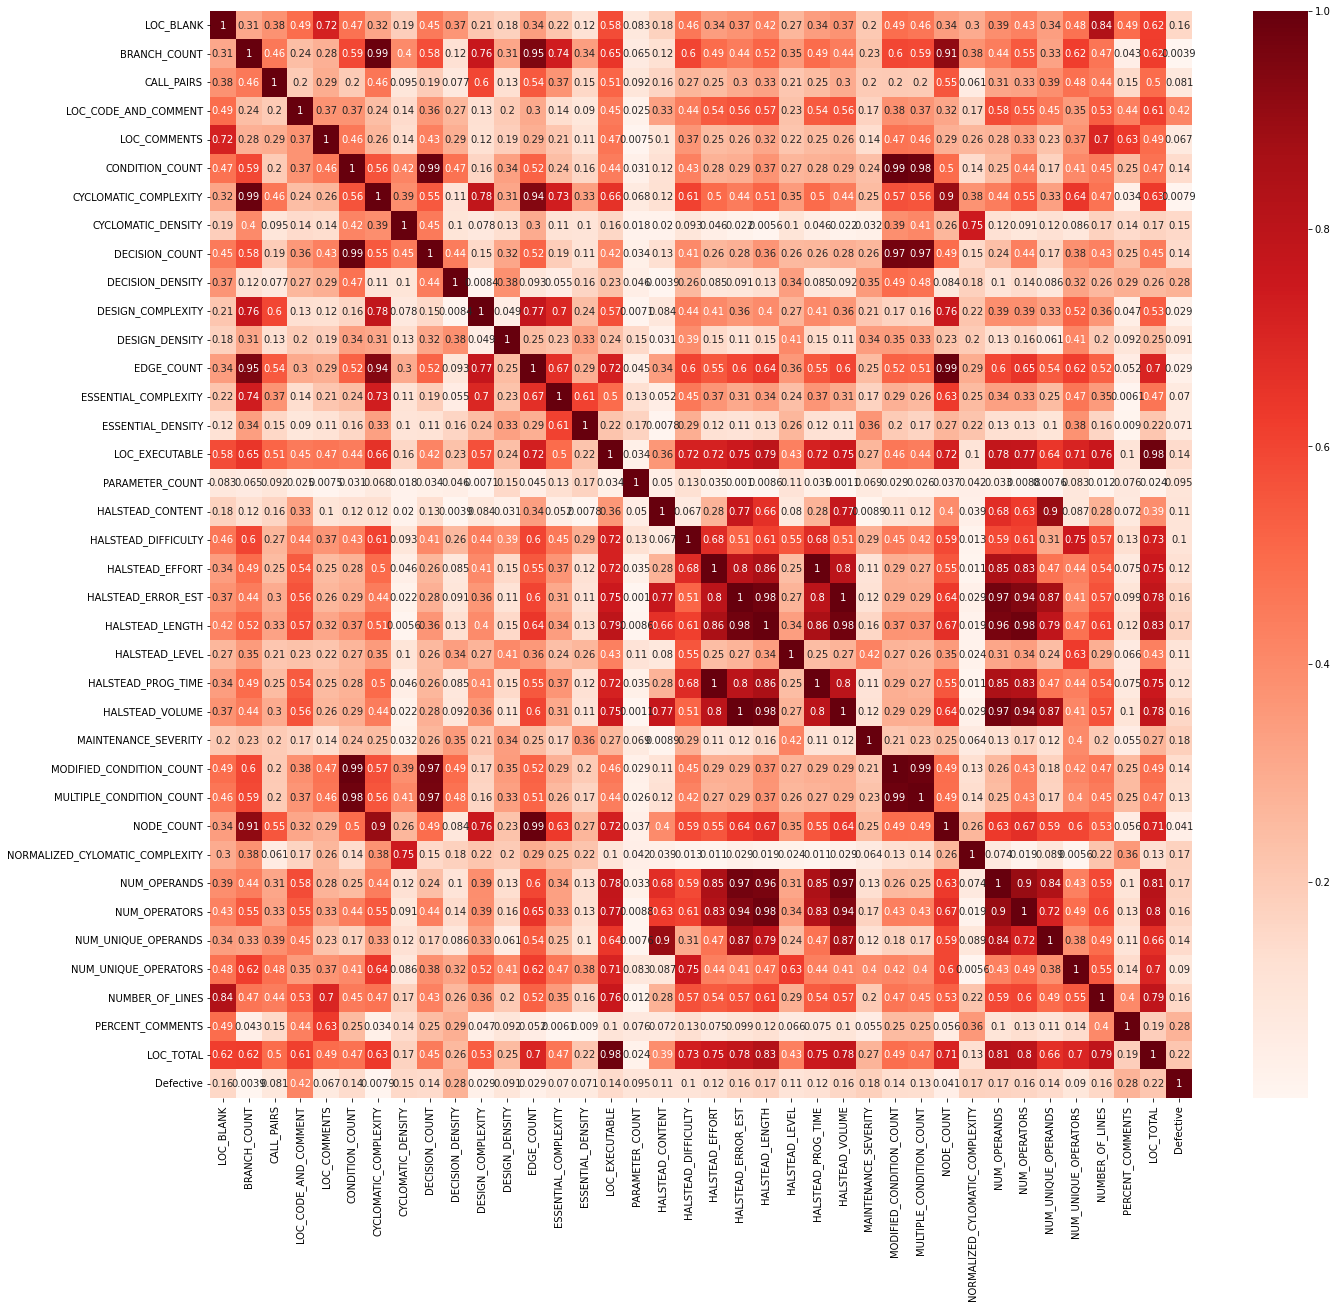

In [10]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [11]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'LOC_TOTAL']


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_DENSITY,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,...,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,Defective
0,8.0,1.0,0.0,0.0,6.0,0.0,0.07,0.00,1.0,1.00,...,5138.91,0.06,0.04,1.00,0.03,2.0,4.0,30.0,28.57,0
1,1.0,7.0,3.0,0.0,0.0,0.0,0.44,0.00,3.0,0.75,...,2820.14,0.09,0.10,0.25,0.25,10.0,12.0,16.0,0.00,0
2,33.0,29.0,7.0,9.0,20.0,52.0,0.25,2.17,8.0,0.53,...,70169.94,0.52,0.02,0.20,0.13,29.0,25.0,115.0,36.25,0
3,1.0,19.0,0.0,17.0,0.0,0.0,0.21,0.00,1.0,0.10,...,66226.00,0.47,0.02,0.80,0.20,28.0,26.0,50.0,35.42,0
4,7.0,13.0,5.0,9.0,9.0,24.0,0.22,2.00,6.0,0.86,...,8555.65,0.18,0.06,0.14,0.14,15.0,13.0,50.0,43.90,1


In [12]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [14]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
print(f"Score: {knn.score(X_test_sfs, y_test)}")
y_pred=knn.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9224806201550387
MCC: 0.4664230734463529


Selected features for KNN

In [15]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_DENSITY', 'DECISION_DENSITY', 'DESIGN_COMPLEXITY',
       'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY', 'HALSTEAD_CONTENT',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_UNIQUE_OPERANDS'],
      dtype='object')

### Naive Bayes

In [16]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
print(f"Score: {gnb.score(X_test_sfs, y_test)}")
y_pred=gnb.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9069767441860465
MCC: 0.40089450007881555


Selected Features for Naive Bayes

In [17]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'DECISION_DENSITY', 'DESIGN_DENSITY', 'ESSENTIAL_DENSITY',
       'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'MAINTENANCE_SEVERITY', 'NUM_UNIQUE_OPERATORS',
       'NUMBER_OF_LINES'],
      dtype='object')

### Decision Tree

In [18]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
print(f"Score: {dtc.score(X_test_sfs, y_test)}")
y_pred=dtc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8397932816537468
MCC: 0.3027681156458089


Selected features for Decision Tree

In [19]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'CONDITION_COUNT', 'DECISION_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT',
       'MAINTENANCE_SEVERITY', 'NUM_UNIQUE_OPERANDS', 'NUMBER_OF_LINES'],
      dtype='object')

### Random Forest

In [20]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
print(f"Score: {rfc.score(X_test_sfs, y_test)}")
y_pred=rfc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9018087855297158
MCC: 0.4331499746000866


Selected features for Random Forest

In [21]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CYCLOMATIC_DENSITY', 'DECISION_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_UNIQUE_OPERANDS',
       'PERCENT_COMMENTS'],
      dtype='object')

### AdaBoost

In [22]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
print(f"Score: {abc.score(X_test_sfs, y_test)}")
y_pred=abc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8888888888888888
MCC: 0.3509395587913706


Selected features for AdaBoost Classifier

In [23]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CONDITION_COUNT', 'CYCLOMATIC_DENSITY', 'DECISION_DENSITY',
       'DESIGN_DENSITY', 'PARAMETER_COUNT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LEVEL',
       'NORMALIZED_CYLOMATIC_COMPLEXITY'],
      dtype='object')